# Project 3

## Loading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [4]:
clean_df = pd.read_csv('/content/drive/MyDrive/DS Project Data/clean_arrest_data.csv')

### Feature Engineering

Updating all of the date and time information since these might be important later on and we would rather deal with them now then have to try and change it later.

In [5]:
clean_df['Arrest_DateTime'] = pd.to_datetime(clean_df['Arrest Date'], errors='coerce')
clean_df['Booking_DateTime'] = pd.to_datetime(clean_df['Booking Date'], errors='coerce')

# Extract day, month, and year for Arrest Date
clean_df['Arrest_Day'] = clean_df['Arrest_DateTime'].dt.day
clean_df['Arrest_Month'] = clean_df['Arrest_DateTime'].dt.month
clean_df['Arrest_Year'] = clean_df['Arrest_DateTime'].dt.year

# Extract day, month, and year for Booking Date
clean_df['Booking_Day'] = clean_df['Booking_DateTime'].dt.day
clean_df['Booking_Month'] = clean_df['Booking_DateTime'].dt.month
clean_df['Booking_Year'] = clean_df['Booking_DateTime'].dt.year

# Check the new columns
clean_df[['Arrest Date', 'Arrest_Day', 'Arrest_Month', 'Arrest_Year', 'Booking Date', 'Booking_Day', 'Booking_Month', 'Booking_Year']].head()

clean_df = clean_df.drop(columns=['Arrest Date', 'Booking Date', 'Arrest_DateTime', 'Booking_DateTime'])

<ipython-input-5-7a8f11a2344d>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df['Arrest_DateTime'] = pd.to_datetime(clean_df['Arrest Date'], errors='coerce')
<ipython-input-5-7a8f11a2344d>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df['Booking_DateTime'] = pd.to_datetime(clean_df['Booking Date'], errors='coerce')


In [6]:
# Updated mapping dictionary for recoding
descent_mapping = {
    # Hispanic/Latino
    'H': 'Hispanic/Latino',

    # Black/African American
    'B': 'Black/African American',

    # White/Caucasian
    'W': 'White/Caucasian',

    # Asian/Pacific Islander (combining Asian and Pacific Islander)
    'A': 'Asian/Pacific Islander',
    'C': 'Asian/Pacific Islander',
    'F': 'Asian/Pacific Islander',
    'K': 'Asian/Pacific Islander',
    'J': 'Asian/Pacific Islander',
    'Z': 'Asian/Pacific Islander',
    'D': 'Asian/Pacific Islander',
    'V': 'Asian/Pacific Islander',
    'L': 'Asian/Pacific Islander',
    'G': 'Asian/Pacific Islander',  # Guamanian
    'P': 'Asian/Pacific Islander',  # Pacific Islander
    'U': 'Asian/Pacific Islander',  # Hawaiian
    'S': 'Asian/Pacific Islander',  # Samoan

    # Other/Unknown (including Native American due to small numbers)
    'I': 'Other/Unknown',  # American Indian/Alaska Native
    'O': 'Other/Unknown',
    'X': 'Other/Unknown'
}

# Apply the mapping to create a new column
clean_df['Ethnicity'] = clean_df['Descent Code'].map(descent_mapping)

In [7]:
clean_df[['Asian/Pacific Islander', 'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian']] = pd.get_dummies(clean_df['Ethnicity'])

In [ ]:
# clean_df = clean_df.drop(columns=['Sex Code', 'Descent Code', 'Ethnicity'])

Grouping the crime category into more manageable columns since this allows for better use in the models. Also I intend to possibly look into making a model predicting this so it allows for a better way to look into it.

In [8]:
def crime_category(charge):
    if charge in ['Aggravated Assault', 'Robbery', 'Homicide', 'Rape', 'Other Assaults']:
        return 'Violent Crime'
    elif charge in ['Narcotic Drug Laws', 'Driving Under Influence', 'Drunkeness', 'Liquor Laws']:
        return 'Drug/Alcohol'
    elif charge in ['Vehicle Theft', 'Burglary', 'Fraud/Embezzlement', 'Larceny', 'Forgery/Counterfeit']:
        return 'Property Crime'
    else:
        return 'Low-Level Offense'

clean_df['Crime Category'] = clean_df['Charge Group Description'].apply(crime_category)

In [9]:
clean_df[['Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']] = pd.get_dummies(clean_df['Crime Category'])

In [10]:
clean_df = clean_df.drop(columns=['Crime Category'])

##Gender Model

This contains the main Random Forest model that I used in the project and gave me the best results. Also, the other models that I tested which were not used since they didn't give as good results. Includes hyperparameters and confusion matrixs to test the model to ensure that the accuracy scores are not leading us astray with the results.

In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [12]:
train_df['Sex Code Numeric'] = train_df['Sex Code'].map({'F': 0, 'M': 1})
test_df['Sex Code Numeric'] = test_df['Sex Code'].map({'F': 0, 'M': 1})

Setting up all of the training and testing information along with resampling since the values were so heavily skewed towards the males. This allowed for us to get better results since there are more even splits within the datasets.

In [13]:
X_train = train_df[['Time','Age', 'Booking Time',
       'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Charge Group Code', 'Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_train = train_df['Sex Code']

X_test = test_df[['Time', 'Age', 'Booking Time',
       'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Charge Group Code', 'Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_test = test_df['Sex Code']

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [15]:
import pandas as pd

# Combine X and y for train and test sets
train_combined = pd.concat([pd.DataFrame(X_train_resampled), pd.DataFrame(y_train_resampled)], axis=1)
test_combined = pd.concat([pd.DataFrame(X_test_resampled), pd.DataFrame(y_test_resampled)], axis=1)


### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=5, max_depth=30, class_weight='balanced', random_state=42)

tree.fit(X_train_resampled, y_train_resampled)
tree_preds = tree.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, tree_preds)
print(f"Accuracy: {score}")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grid
param_grid = {
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get best parameters
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on test data
tree_preds = best_tree.predict(X_test_resampled)
score = accuracy_score(y_test_resampled, tree_preds)

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {score}")


Splits about 0.72 / 0.75 for the true negatives and true positives

In [ ]:
cm = confusion_matrix(y_test_resampled, tree_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=2000)

log_reg.fit(X_train_resampled, y_train_resampled)

log_reg_preds = log_reg.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, log_reg_preds)
print(f"Accuracy: {score}")

In [ ]:
cm = confusion_matrix(y_test_resampled, log_reg_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Random Forest Model

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, n_jobs=-1, class_weight='balanced')

clf.fit(X_train_resampled, y_train_resampled)

rf_preds = clf.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, rf_preds)
print(f"Accuracy: {score}")

Accuracy: 0.8537093208575395


In [19]:
test_combined['RF Preds'] = rf_preds

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import re

dot_data = export_graphviz(clf.estimators_[0], out_file=None,
                           feature_names=X_train.columns,
                           class_names=["Female", "Male"],
                           filled=True, rounded=True,
                           max_depth=3, impurity=False)

filtered_dot_data = re.sub(r'value = \[.*?\]\\n', '', dot_data)
graph = graphviz.Source(filtered_dot_data)
graph.render("tree4")

Checking for the most important features and after every test to see how things are changing to see if we need to add or remove certain columns

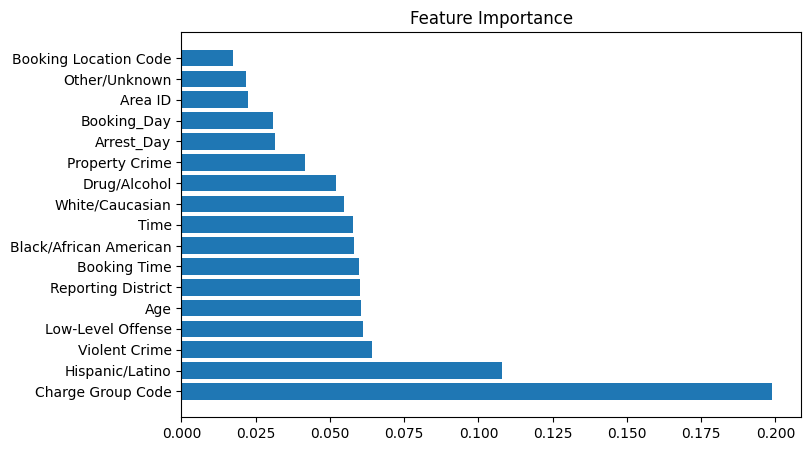

In [34]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

Splits about 0.64 / 0.95 with the true negatives and true positives. Pretty good accuracy but struggles with the true negatives (hyperparameter tuning or is there something else affecting it)

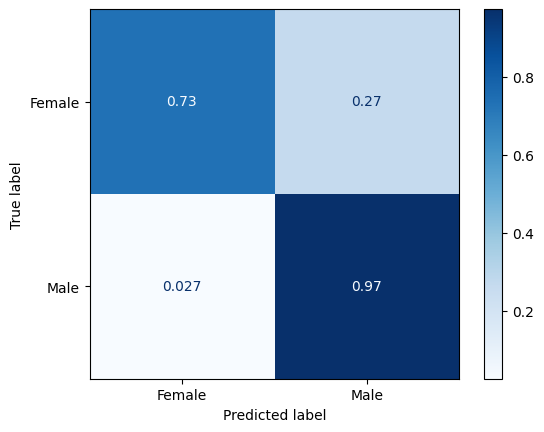

In [17]:
labels = ['Female', 'Male']
cm = confusion_matrix(y_test_resampled, rf_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

### XG Boost Model

In [ ]:
train_df['Sex Code Numeric'] = train_df['Sex Code'].map({'F': 0, 'M': 1})
test_df['Sex Code Numeric'] = test_df['Sex Code'].map({'F': 0, 'M': 1})

In [ ]:
X_train = train_df[['Time', 'Age', 'Booking Time',
       'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Charge Group Code', 'Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_train = train_df['Sex Code Numeric']

X_test = test_df[['Time', 'Age', 'Booking Time',
       'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Charge Group Code', 'Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_test = test_df['Sex Code Numeric']

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [ ]:
from xgboost.sklearn import XGBClassifier


xgb_clf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=.1, n_jobs=-1, subsample=0.5, colsample_bytree=0.6)

xgb_clf.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = xgb_clf.predict(X_test_resampled)

# Compute confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred, normalize='true')

# Display confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="viridis", values_format=".2f")

### Looking into females predicted as males

In [20]:
test_combined.head()

,Time,Age,Booking Time,Booking Location Code,Arrest_Day,Booking_Day,Charge Group Code,Area ID,Reporting District,Black/African American,Hispanic/Latino,Other/Unknown,White/Caucasian,Violent Crime,Drug/Alcohol,Property Crime,Low-Level Offense,Sex Code,RF Preds
0,1920.0,23,2006.0,4206.0,8,8,3.0,6,668,True,False,False,False,False,False,False,True,M,M
1,1430.0,34,1707.0,4279.0,7,7,17.0,21,2146,False,False,False,True,True,False,False,False,F,M
2,145.0,25,710.0,4279.0,3,3,4.0,15,1508,False,True,False,False,False,False,False,True,M,M
3,1515.0,22,1715.0,4279.0,11,11,24.0,10,1047,False,True,False,False,False,True,False,False,M,M
4,1840.0,26,2117.0,4273.0,1,1,6.0,2,281,True,False,False,False,False,False,True,False,M,M


In [21]:
incorrect_males = test_combined[(test_combined['Sex Code'] == 'F') & (test_combined['RF Preds'] == 'M')]

In [23]:
correct_females = test_combined[test_combined['Sex Code'] == 'F']

Another thing to look into was the Booking and Arrest days since there was a major difference between the correct and incorrrect groups. There were spikes on days 1, 15, and 30 in the incorrect_males where the correct_females follwed a general pattern.

The model may be overfitting to geographic location—certain areas may be predominantly male in the training data, causing misclassifications. Misclassified females seem to cluster at specific locations, indicating that the model may associate certain booking locations with males.

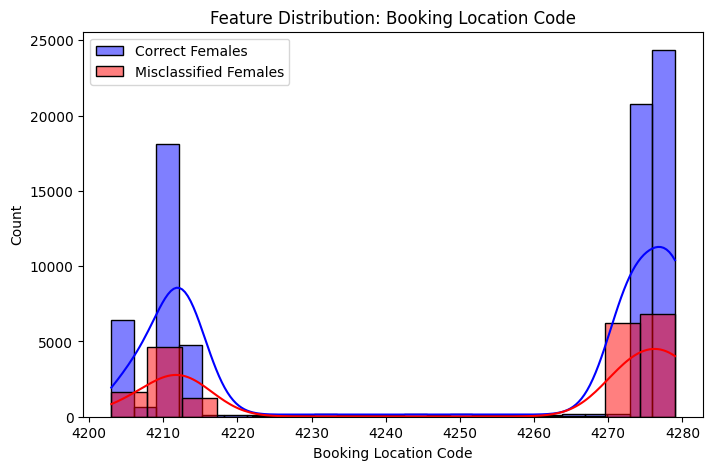

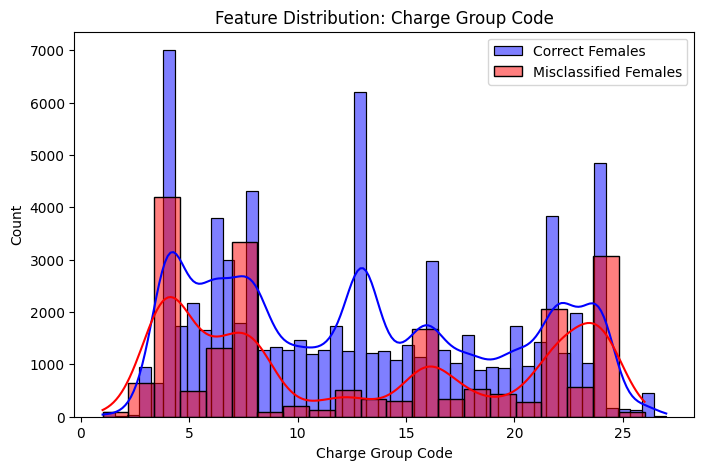

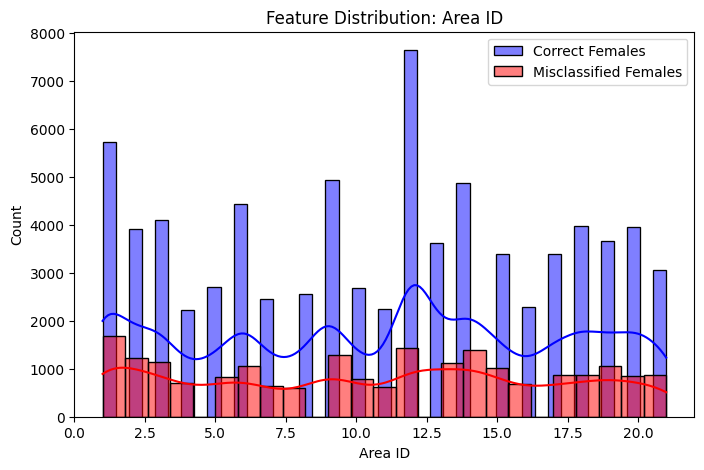

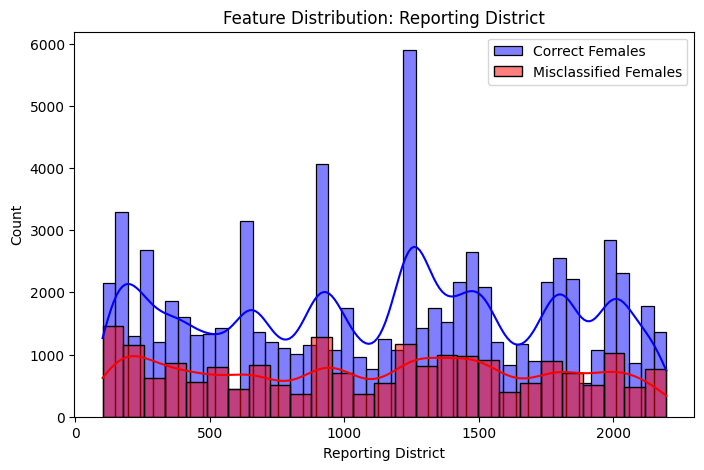

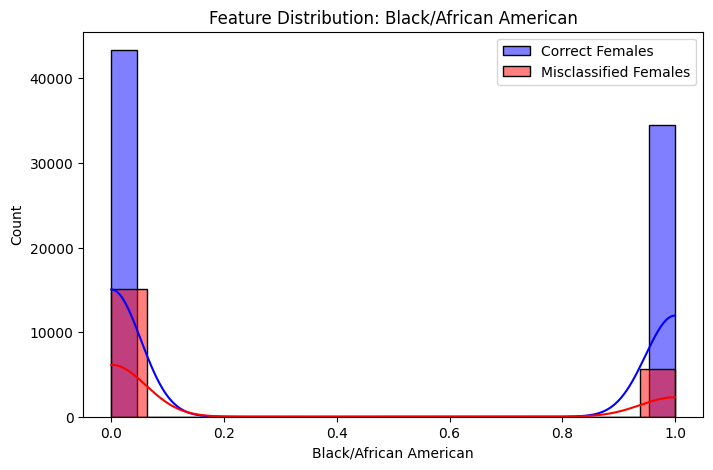

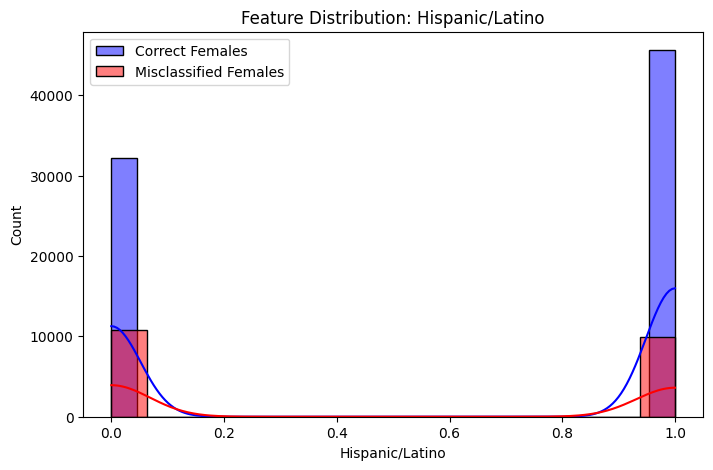

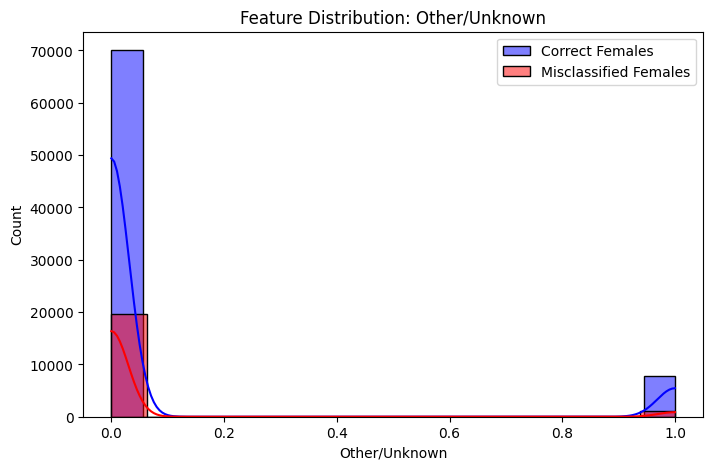

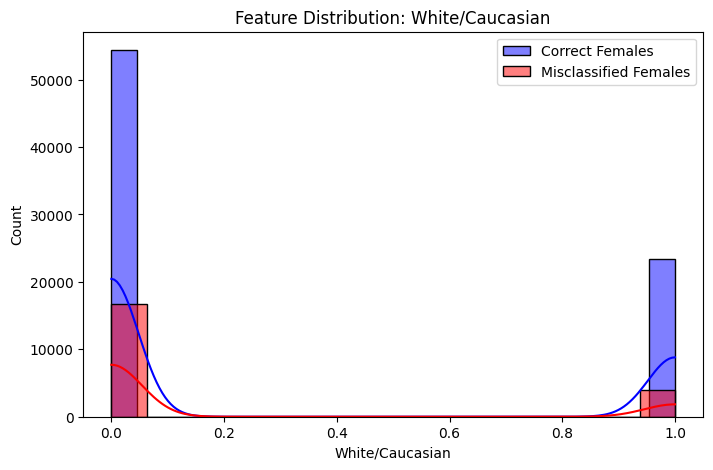

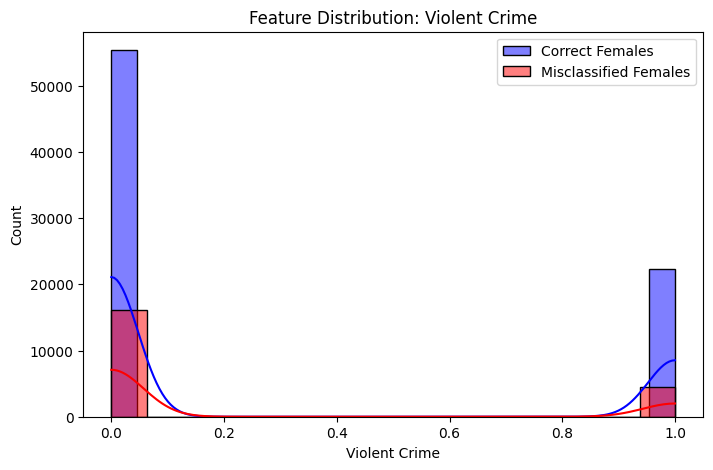

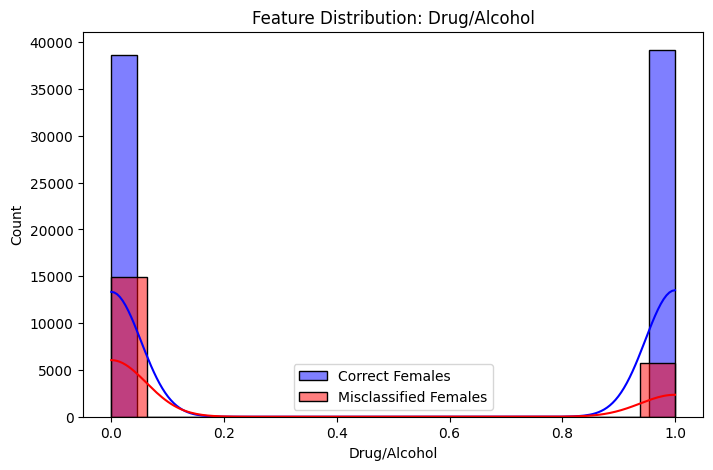

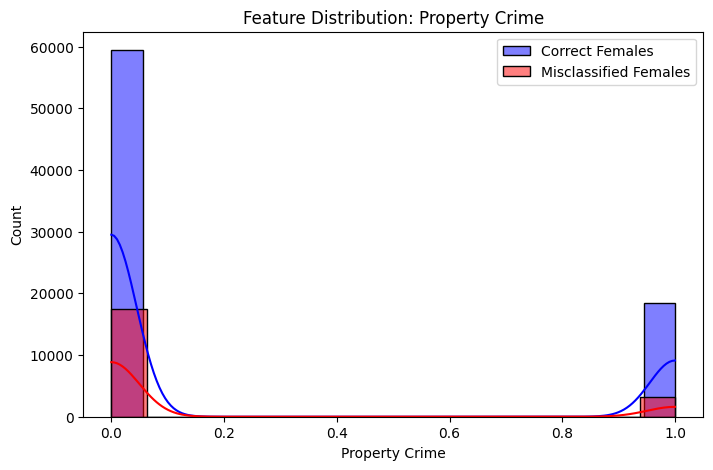

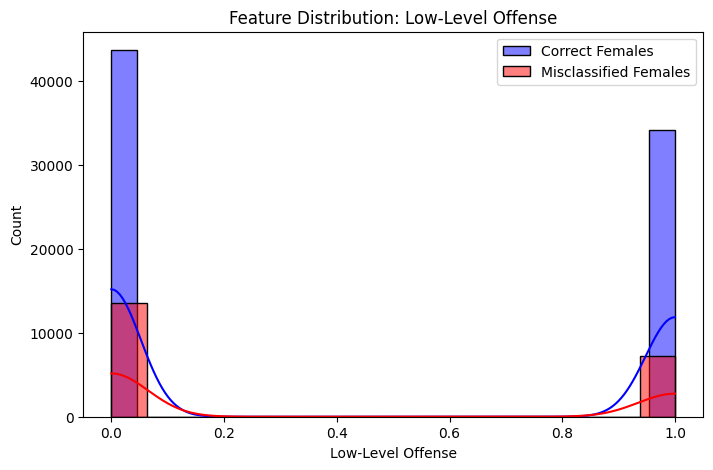

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select features of interest
features = ['Booking Location Code','Charge Group Code', 'Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown',
       'White/Caucasian', 'Violent Crime', 'Drug/Alcohol', 'Property Crime',
       'Low-Level Offense',]  # Replace with actual feature names

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(correct_females[feature], label="Correct Females", color="blue", kde=True, alpha=0.5)
    sns.histplot(incorrect_males[feature], label="Misclassified Females", color="red", kde=True, alpha=0.5)
    plt.title(f"Feature Distribution: {feature}")
    plt.legend()
    plt.show()


When looking at different features there was a big disparity between the amount of true and falses in the correct vs incorrect groups

In [30]:
correct_females['Drug/Alcohol'].value_counts()

,count
Drug/Alcohol,
True,39155
False,38649


In [31]:
incorrect_males['Drug/Alcohol'].value_counts()

,count
Drug/Alcohol,
False,14905
True,5781


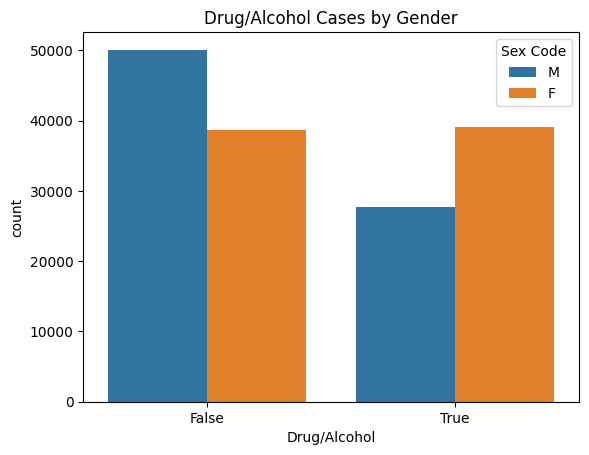

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare the proportion of Drug/Alcohol cases between groups
sns.countplot(x='Drug/Alcohol', hue='Sex Code', data=test_combined)
plt.title("Drug/Alcohol Cases by Gender")
plt.show()


Tested out a new model to see if dropping this column allowed for better results

In [36]:
X_train_mod = X_train_resampled.drop(columns=['Drug/Alcohol'])
X_test_mod = X_test_resampled.drop(columns=['Drug/Alcohol'])

clf.fit(X_train_mod, y_train_resampled)
y_pred_mod = clf.predict(X_test_mod)

from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_mod))

              precision    recall  f1-score   support

           F       0.96      0.73      0.83     77804
           M       0.78      0.97      0.87     77804

    accuracy                           0.85    155608
   macro avg       0.87      0.85      0.85    155608
weighted avg       0.87      0.85      0.85    155608



### Voting Classifier

Tried to combine all of the models that I created together hoping that it would produce a better result. Tested with both Hard and Soft voting to see which one would produce better results

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('decisionTree', tree), ('randomForest', clf), ('xg boost', xgb_clf)], voting='hard')

# Train on resampled data
voting_clf.fit(X_train_resampled, y_train_resampled)

# Predict
vc_preds = voting_clf.predict(X_test_resampled)

In [ ]:
labels = ['Female', 'Male']
cm = confusion_matrix(y_test_resampled, vc_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
score = accuracy_score(y_test_resampled, vc_preds)
print(f"Accuracy: {score}")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, vc_preds))

## Other Models Tested

Others Models that I just took some basic looks into to see how they would perform but did not end up using them since they really struggled to predict any solid answers. So this is just some scratch work that never really ever got used

### Charge Type Model

In [ ]:
clean_df[['Female', 'Male']] = pd.get_dummies(clean_df['Sex Code'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming your target column is named 'crime_category'
label_encoder = LabelEncoder()
clean_df['crime_category_encoded'] = label_encoder.fit_transform(clean_df['Crime Category'])

# Now 'crime_category_encoded' will have values like 0, 1, 2, etc.

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [ ]:
X_train = train_df[['Time','Age', 'Booking Time',  'Female',
       'Male', 'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Asian/Pacific Islander','Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian']]
y_train = train_df['crime_category_encoded']

X_test = test_df[['Time','Age', 'Booking Time',  'Female',
       'Male', 'Booking Location Code', 'Arrest_Day',
       'Booking_Day', 'Asian/Pacific Islander','Area ID', 'Reporting District',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian']]
y_test = test_df['crime_category_encoded']

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, n_jobs=-1, class_weight='balanced')

clf.fit(X_train_resampled, y_train_resampled)

preds = clf.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, preds)
print(f"Accuracy: {score}")

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.show()

In [ ]:
cm = confusion_matrix(y_test_resampled, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Location Model

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [ ]:
clean_df.columns

In [ ]:
X_train = train_df[['Time','Age', 'Sex Code Numeric',
                  'Arrest_Day', 'Arrest_Month', 'Arrest_Year', 'Asian/Pacific Islander',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian']]
y_train = train_df['Area ID']

X_test = test_df[['Time','Age', 'Sex Code Numeric',
                  'Arrest_Day', 'Arrest_Month', 'Arrest_Year', 'Asian/Pacific Islander',
       'Black/African American', 'Hispanic/Latino', 'Other/Unknown', 'White/Caucasian']]
y_test = test_df['Area ID']

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, n_jobs=-1, class_weight='balanced')

clf.fit(X_train_resampled, y_train_resampled)

preds = clf.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, preds)
print(f"Accuracy: {score}")

In [ ]:
cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Ethnicity Model

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [ ]:
X_train = train_df[['Time','Age', 'Sex Code Numeric',
                  'Arrest_Day', 'Arrest_Month', 'Arrest_Year', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_train = train_df['Ethnicity']

X_test = test_df[['Time','Age', 'Sex Code Numeric',
                  'Arrest_Day', 'Arrest_Month', 'Arrest_Year', 'Violent Crime', 'Drug/Alcohol', 'Property Crime', 'Low-Level Offense']]
y_test = test_df['Ethnicity']

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, n_jobs=-1, class_weight='balanced')

clf.fit(X_train_resampled, y_train_resampled)

preds = clf.predict(X_test_resampled)

score = accuracy_score(y_test_resampled, preds)
print(f"Accuracy: {score}")